# Training a Boltzmann Generator for Hydrogen peroxide

This notebook introduces basic concepts behind `bgflow`. 

It shows how to build an train a Boltzmann generator for a small peptide. The most important aspects it will cover are

- retrieval of molecular training data
- defining a internal coordinate transform
- defining normalizing flow classes
- combining different normalizing flows
- training a Boltzmann generator via NLL and KLL

The main purpose of this tutorial is to introduce the implementation. The network design is optimized for educational purposes rather than good performance. In the conlusions, we will discuss some aspects of the generator that are not ideal and outline improvements.

## Some Preliminaries

We instruct jupyter to reload any imports automatically and define the device and datatype, on which we want to perform the computations.

In [1]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = torch.zeros([], device=device, dtype=dtype)

# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")



## Load the Data and the Molecular System

Molecular trajectories and their corresponding potential energy functions are available from the `bgmol` repository.

In [2]:
import numpy as np
import mdtraj

In [4]:
# import os
# from bgmol.datasets import Ala2TSF300

# is_data_here = os.path.isfile("Ala2TSF300.npy")
# datasetf = Ala2TSF300(download=(not is_data_here), read=True)
# systemf = datasetf.system
# coordinatesf = datasetf.coordinates
# temperaturef = datasetf.temperature
# dimf = datasetf.dim

Using downloaded and verified file: /tmp/alanine-dipeptide-nowater.pdb


In [3]:
#dataset = mdtraj.load('output.dcd', top='ala2_fromURL.pdb')
dataset = mdtraj.load('h2o2trajectory.dcd', top='H2O2_explicitH.pdb')
fname = "h2o2"
coordinates = dataset.xyz
print(dataset)

<mdtraj.Trajectory with 250000 frames, 4 atoms, 1 residues, without unitcells>


In [ ]:
import nglview
view = nglview.show_mdtraj(dataset)
view

In [4]:
n_iter_NLL = 20000
n_iter_mixed = 2000

In [5]:
#coordinatestrunc = coordinates[::2,:,:]
print(coordinates.size)
#print(coordinatestrunc.size)

3000000


import numpy as np
rigid_block = np.array([6, 8, 9, 10, 14])
z_matrix = np.array([
    [0, 1, 4, 6],
    [1, 4, 6, 8],
    [2, 1, 4, 0],
    [3, 1, 4, 0],
    [4, 6, 8, 14],
    [5, 4, 6, 8],
    [7, 6, 8, 4],
    [11, 10, 8, 6],
    [12, 10, 8, 11],
    [13, 10, 8, 11],
    [15, 14, 8, 16],
    [16, 14, 8, 6],
    [17, 16, 14, 15],
    [18, 16, 14, 8],
    [19, 18, 16, 14],
    [20, 18, 16, 19],
    [21, 18, 16, 19]
])

In [6]:

def dimensions(dataset):
        return np.prod(dataset.xyz[0].shape)
dim = int(dimensions(dataset))
print(dim)


12


The energy model is a `bgflow.Energy` that wraps around OpenMM. The `n_workers` argument determines the number of openmm contexts that are used for energy evaluations. In notebooks, we set `n_workers=1` to avoid hickups. In production, we can omit this argument so that `n_workers` is automatically set to the number of CPU cores.

In [7]:
from simtk import openmm
with open('xml_system.txt') as f:
    xml = f.read()
system = openmm.XmlSerializer.deserialize(xml)

In [ ]:
#making the openmm system used for the energy bridge
# from simtk import unit
# from simtk.openmm import app
# from openff.toolkit.topology import Molecule
# from openff.toolkit.typing.engines.smirnoff import ForceField
# h2o2 = Molecule.from_pdb_and_smiles('H2O2_explicitH.pdb','OO')
# off_topology = h2o2.to_topology()
# omm_topology = off_topology.to_openmm()
# positions = h2o2.conformers[0]

# pdb = app.PDBFile('H2O2_explicitH.pdb')
# forcefield = ForceField("openff-2.0.0.offxml")
# system = forcefield.create_openmm_system(topology=off_topology)

In [8]:
import bgflow
from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
from openmmtools import integrators
from simtk import unit
temperature = 300.0 * unit.kelvin
collision_rate = 1.0 / unit.picosecond
timestep = 2.0 * unit.femtosecond

integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

energy_bridge = OpenMMBridge(system, integrator, platform_name='CUDA',n_workers=1)
target_energy = OpenMMEnergy(dim, energy_bridge)

In [9]:
print(coordinates[0].reshape(-1,12))
target_energy.energy(torch.tensor(coordinates[0].reshape(-1,12)).to(ctx))

[[3.7229993 4.835657  2.3863068 3.6135375 4.8392873 2.4883826 3.741987
  4.92164   2.3452222 3.5334785 4.797921  2.4520378]]


tensor([[31.4105]], device='cuda:0')

### Visualize Data: Ramachandran Plot for the Backbone Angles

## Split Data and Randomly Permute Samples

In [10]:
n_train = len(dataset)//2
n_test = len(dataset) - n_train
permutation = np.random.permutation(n_train)

all_data = coordinates.reshape(-1, dimensions(dataset))
training_data = torch.tensor(all_data[permutation]).to(ctx)
test_data = torch.tensor(all_data[permutation + n_train]).to(ctx)

## Define the Internal Coordinate Transform

Rather than generating all-Cartesian coordinates, we use a mixed internal coordinate transform.
The five central alanine atoms will serve as a Cartesian "anchor", from which all other atoms are placed with respect to internal coordinates (IC) defined through a z-matrix. We have deposited a valid `z_matrix` and the corresponding `rigid_block` in the `dataset.system` from `bgmol`.

In [12]:
import bgflow as bg

In [16]:
# throw away 6 degrees of freedom (rotation and translation)
# dim_cartesian = len(rigid_block) * 3 - 6
# print(dim_cartesian)
# #dim_cartesian = len(system.rigid_block) * 3
# dim_bonds = len(z_matrix)
# print(dim_bonds)
# dim_angles = dim_bonds
# dim_torsions = dim_bonds

9
17


In [17]:
# coordinate_transform = bg.MixedCoordinateTransformation(
#     data=training_data, 
#     z_matrix=z_matrix,
#     fixed_atoms=rigid_block,
#     #keepdims=None,
#     keepdims=dim_cartesian, 
#     normalize_angles=True,
# ).to(ctx)

For demonstration, we transform the first 3 samples from the training data set into internal coordinates as follows:

In [18]:
# bonds, angles, torsions, cartesian, dlogp = coordinate_transform.forward(training_data[:3])
# bonds.shape, angles.shape, torsions.shape, cartesian.shape, dlogp.shape
# #print(bonds)

(torch.Size([3, 17]),
 torch.Size([3, 17]),
 torch.Size([3, 17]),
 torch.Size([3, 9]),
 torch.Size([3, 1]))

## Prior Distribution

The next step is to define a prior distribution that we can easily sample from. The normalizing flow will be trained to transform such latent samples into molecular coordinates. Here, we just take a normal distribution, which is a rather naive choice for reasons that will be discussed in other notebooks.

In [13]:
# dim_ics = dim_bonds + dim_angles + dim_torsions + dim_cartesian
mean = torch.zeros(dim).to(ctx) 
# passing the mean explicitly to create samples on the correct device
prior = bg.NormalDistribution(dim=dim, mean=mean)


## Normalizing Flow

Next, we set up the normalizing flow by stacking together different neural networks. For now, we will do this in a rather naive way, not distinguishing between bonds, angles, and torsions. Therefore, we will first define a flow that splits the output from the prior into the different IC terms.

### Split Layer

In [20]:
#split_into_ics_flow = bg.SplitFlow(dim_bonds, dim_angles, dim_torsions, dim_cartesian)

In [21]:
# test
#print(prior.sample(3))
#_ics = split_into_ics_flow(prior.sample(1))
#print(_ics)
#coordinate_transform.forward(*_ics, inverse=True)[0].shape

torch.Size([1, 66])

### Coupling Layers

Next, we will set up so-called RealNVP coupling layers, which split the input into two channels and then learn affine transformations of channel 1 conditioned on channel 2. Here we will do the split naively between the first and second half of the degrees of freedom.

In [14]:
class RealNVP(bg.SequentialFlow):
    
    def __init__(self, dim, hidden):
        self.dim = dim
        self.hidden = hidden
        super().__init__(self._create_layers())
    
    def _create_layers(self):
        dim_channel1 =  self.dim//2
        dim_channel2 = self.dim - dim_channel1
        split_into_2 = bg.SplitFlow(dim_channel1, dim_channel2)
        
        layers = [
            # -- split
            split_into_2,
            # --transform
            self._coupling_block(dim_channel1, dim_channel2),
            bg.SwapFlow(),
            self._coupling_block(dim_channel2, dim_channel1),
            # -- merge
            bg.InverseFlow(split_into_2)
        ]
        return layers
        
    def _dense_net(self, dim1, dim2):
        return bg.DenseNet(
            [dim1, *self.hidden, dim2],
            activation=torch.nn.ReLU()
        )
    
    def _coupling_block(self, dim1, dim2):
        return bg.CouplingFlow(bg.AffineTransformer(
            shift_transformation=self._dense_net(dim1, dim2),
            scale_transformation=self._dense_net(dim1, dim2)
        ))
    

In [15]:
RealNVP(dim, hidden=[128]).to(ctx).forward(prior.sample(3))[0].shape

torch.Size([3, 12])

### Boltzmann Generator

Finally, we define the Boltzmann generator.
It will sample molecular conformations by 

1. sampling in latent space from the normal prior distribution,
2. transforming the samples into a more complication distribution through a number of RealNVP blocks (the parameters of these blocks will be subject to optimization),
3. splitting the output of the network into blocks that define the internal coordinates, and
4. transforming the internal coordinates into Cartesian coordinates through the inverse IC transform.

In [16]:
n_realnvp_blocks = 5
layers = []

for i in range(n_realnvp_blocks):
    layers.append(RealNVP(dim, hidden=[128, 128, 128]))
# layers.append(split_into_ics_flow)
# layers.append(bg.InverseFlow(coordinate_transform))

flow = bg.SequentialFlow(layers).to(ctx)

In [17]:
# test
flow.forward(prior.sample(3))[0].shape

torch.Size([3, 12])

In [18]:
# print number of trainable parameters
"#Parameters:", np.sum([np.prod(p.size()) for p in flow.parameters()])

('#Parameters:', 693890)

In [19]:
generator = bg.BoltzmannGenerator(
    flow=flow,
    prior=prior,
    target=target_energy
)

In [20]:
import matplotlib.pyplot as plt
def plot_energies(ax, samples, target_energy, test_data):
    sample_energies = target_energy.energy(samples).cpu().detach().numpy()
    md_energies = target_energy.energy(test_data[:len(samples)]).cpu().detach().numpy()
    cut = max(np.percentile(sample_energies, 80), 20)
    
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    ax2.hist(sample_energies, range=(-50, cut), bins=40, density=False, label="BG")
    ax2.hist(md_energies, range=(-50, cut), bins=40, density=False, label="MD")
    ax2.set_ylabel(f"Count   [#Samples / {len(samples)}]")
    ax2.legend()

## Train

Boltzmann generators can be trained in two ways:
1. by matching the density of samples from the training data via the negative log likelihood (NLL), and
2. by matching the target density via the backward Kullback-Leibler loss (KLL).

NLL-based training is faster, as it does not require the computation of molecular target energies. Therefore, we will first train the generator solely by density estimation.

### NLL Training

In [21]:
nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
nll_trainer = bg.KLTrainer(
    generator, 
    optim=nll_optimizer,
    train_energy=False
)

In [22]:

nll_trainer.train(
    n_iter=n_iter_NLL, 
    data=training_data,
    batchsize=128,
    n_print=10, 
    w_energy=0.0
)

1	NLL: 206013.0000	
11	NLL: 2694.3208	
21	NLL: 1434.2847	
31	NLL: 711.3226	
41	NLL: 380.7439	
51	NLL: 283.7220	
61	NLL: 171.9790	
71	NLL: 115.7380	
81	NLL: 89.5019	
91	NLL: 72.4169	
101	NLL: 61.7869	
111	NLL: 65.1102	
121	NLL: 62.6636	
131	NLL: 53.8399	
141	NLL: 51.1661	
151	NLL: 48.2501	
161	NLL: 47.0388	
171	NLL: 55.6859	
181	NLL: 50.1160	
191	NLL: 46.0293	
201	NLL: 42.4991	
211	NLL: 41.4817	
221	NLL: 41.3141	
231	NLL: 75.0023	
241	NLL: 59.6879	
251	NLL: 53.5667	
261	NLL: 51.5164	
271	NLL: 49.6151	
281	NLL: 46.0634	
291	NLL: 43.4530	
301	NLL: 42.3940	
311	NLL: 40.4143	
321	NLL: 39.9065	
331	NLL: 39.6232	
341	NLL: 39.0932	
351	NLL: 38.9897	
361	NLL: 41.5061	
371	NLL: 55.8488	
381	NLL: 43.2439	
391	NLL: 40.3105	
401	NLL: 39.1235	
411	NLL: 38.9450	
421	NLL: 39.2850	
431	NLL: 42.1005	
441	NLL: 46.1894	
451	NLL: 52.7881	
461	NLL: 58.9186	
471	NLL: 46.5129	
481	NLL: 45.1863	
491	NLL: 41.8687	
501	NLL: 40.0262	
511	NLL: 38.5034	
521	NLL: 37.9669	
531	NLL: 37.4871	
541	NLL: 36.9616	
551	NLL:

To see what the generator has learned so far, let's first create a bunch of samples and compare their backbone angles with the molecular dynamics data. Let's also plot their energies.

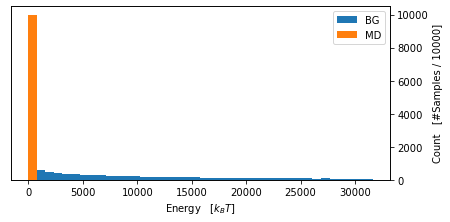

In [24]:
n_samples = 10000
samples = generator.sample(n_samples)

fig, axes = plt.subplots(1, 1, figsize=(6,3))
fig.tight_layout()

plot_energies(axes, samples, target_energy, test_data)
#plt.savefig("NLL_learnt.png")

del samples

### Mixed Training

The next step is "mixed" training with a combination of NLL and KLL. To retain some of the progress made in the NLL phase, we decrease the learning rate and increase the batch size.

In [25]:
mixed_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
mixed_trainer = bg.KLTrainer(
    generator, 
    optim=mixed_optimizer,
    train_energy=True
)

Mixed training will be considerably slower. 
To speed it up, you can change the settings for the OpenMM energy when creating the energy model. For example, consider not passing `n_workers=1`.

To avoid large potential energy gradients from singularities, the components of the KL gradient are constrained to (-100, 100). 

In [26]:
mixed_trainer.train(
    n_iter=n_iter_mixed, 
    data=training_data,
    batchsize=1000,
    n_print=50, 
    w_energy=0.1,
    w_likelihood=0.9,
    clip_forces=20.0
    )

1	KLL: 22568.1523	NLL: 20.6052	
51	KLL: 7221.1660	NLL: 16.9680	
101	KLL: 3637.4922	NLL: 18.0821	
151	KLL: 130011.1641	NLL: 105.9412	
201	KLL: 54250.4961	NLL: 206.6138	
251	KLL: 2602.6362	NLL: 106.2821	
301	KLL: 1721.5236	NLL: 70.9984	
351	KLL: 1294.0045	NLL: 53.6933	
401	KLL: 1035.9650	NLL: 48.4543	
451	KLL: 872.5392	NLL: 45.3537	
501	KLL: 875.2495	NLL: 43.1952	
551	KLL: 640.1132	NLL: 40.9889	
601	KLL: 647.7073	NLL: 39.2242	
651	KLL: 644.2008	NLL: 39.2120	
701	KLL: 502.2064	NLL: 38.2940	
751	KLL: 501.7131	NLL: 37.6679	
801	KLL: 414.0760	NLL: 36.8250	
851	KLL: 423.8442	NLL: 36.1988	
901	KLL: 454.8647	NLL: 35.4813	
951	KLL: 369.0773	NLL: 35.5136	
1001	KLL: 365.8578	NLL: 34.3802	
1051	KLL: 361.1872	NLL: 34.2435	
1101	KLL: 363.1645	NLL: 33.4903	
1151	KLL: 345.5519	NLL: 33.5851	
1201	KLL: 340.5689	NLL: 32.8655	
1251	KLL: 330.3989	NLL: 32.7828	
1301	KLL: 340.4210	NLL: 31.9784	
1351	KLL: 342.4793	NLL: 31.6836	
1401	KLL: 304.9456	NLL: 31.4018	
1451	KLL: 300.0392	NLL: 31.1682	
1501	KLL: 312.631

Plot the results:

In [31]:
torch.save(flow.state_dict(),f'model{fname}.pt')

tensor([[ 29.4173,  50.2962, -19.1353,  ...,  30.4714,  53.5189, -20.2625],
        [ -2.9943,  70.7055, -42.7143,  ...,  -2.4652,  74.2406, -43.5355],
        [ -9.2961,  59.6949,  11.5582,  ...,  -9.0553,  64.4783,  11.8031],
        ...,
        [-37.8264,  31.8134,  -2.0082,  ..., -37.2356,  33.9352,  -2.2178],
        [-19.7331,  46.1491, -29.8722,  ..., -19.0622,  49.1411, -30.6900],
        [-14.3481,  39.5710,  20.1336,  ..., -15.0459,  43.0670,  19.5297]],
       device='cuda:0', grad_fn=<CatBackward>)


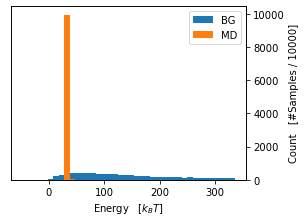

In [30]:
n_samples = 10000
samples = generator.sample(n_samples)
print(samples)

fig, axes = plt.subplots(1, 1, figsize=(4,3))
fig.tight_layout()

#samplestrajectory = plot_phi_psi(axes[0], samples)
plot_energies(axes, samples, target_energy, test_data)
#plt.savefig(f"varysnapshots/{fname}.png", bbox_inches = 'tight')

#samplestrajectory.save("samplestraj.dcd")

#del samples

With nglview installed, we can also take a look at the samples.

In [35]:
import nglview as nv

#samplestrajectory = mdtraj.Trajectory(
#    xyz=samples.cpu().detach().numpy().reshape(-1, 22, 3),
#    topology="ala2_fromURL.pdb")

samplestrajectory.save(f"{fname}_samplestraj.dcd")
#mdtraj.save(samplestrajectory, "obcstride10Samplestraj.dcd")

widget = nv.show_mdtraj(samplestrajectory)

widget

NGLWidget(max_frame=9999)

## Conclusions

This tutorial has introduced the most basic concepts and implementations underlying Boltzmann generators and `bgflow`. That said, the trained networks did not do a particularly good job in reproducing the molecular Boltzmann distribution. Specifically, they only modeled the major modes of the $\phi$ angle and still produced many samples with unreasonably large energies. Let's look at a few shortcomings of the present architecture:

### 1) Unconstrained Internal Coordinates
Bonds, angles, and torsions must not take arbitrary values in principle. Bond lengths need to be positive, angles live in $[0,\pi],$ and torsions are periodic in $[-\pi, \pi].$ Neither those bounds nor the periodicity of torsions distributions have been taken into account by the present Boltzmann generator. The layers of the normalizing flow should be build in a way that preserves these constraints on the ICs.

### 2)  Arbitrary Coupling
The input for the coupling layers was split into two channels rather arbitrarily (first vs. second half). A partial remedy is to define the conditioning in a physically informed manner. Another solution is to augment the base space by momenta, which can be done with augmented normalizing flows (see for instance the notebook on temperature-steering flows).

### 3) RealNVP Layers
Affine coupling layers are well-known to perform poorly in separating modes. This explains that the metastable region around $\phi \approx \pi/2$ was not captured by the generator. Other architectures such as augmented flows or neural spline flows do a better job for complicated, multimodal distributions.

### 4) Training
The generators were only trained for relatively few iterations and performance may improve with longer training and better choices of the learning rate and hyperparameters.